### This Loop is going to do a few things. Mainly, I am trying to save the Skill Scores of this NAO Model->Temp to look at how well it's performing.

I may tack on some of those bar plots from Mayer and Barnes (2021) here at the end. 

I will have a separate coding file to do LRP. (THIS IS A LIE LOL, LRP is also in here).

In [1]:
%matplotlib inline
##so-called "math" related imports
from netCDF4 import Dataset as ncread
import numpy as np
from scipy.io import loadmat
import pandas as pd
import h5py
import math
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
import xarray as xr

import pickle

#plotting related imports
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
from cartopy import crs as ccrs #Useful for plotting maps
import cartopy.util #Requires separate import
from cartopy.util import add_cyclic_point
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.path as mpath
import matplotlib.colors as mcolors

##import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.callbacks import EarlyStopping

tf.compat.v1.disable_eager_execution()
import innvestigate

/tmp/ipykernel_2177897/2580141331.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-11-19 18:25:44.666869: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 18:25:44.666936: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 18:25:44.666975: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Un

In [2]:
#import definitions from skill stat file
from SkillStats_MOD import BSS
from SkillStats_MOD import RAS_two
from SkillStats_MOD import PAS_two
from climoprobs import climo

import random
import sklearn

In [3]:
#inputs ... CHANGE FOR WHATEVER REGION YOU WANT TO LOOK AT 
infile = open("../data/ANN/1118_filtered_gph.p", 'rb') 
input = pickle.load(infile)
infile.close()

infile = open("../data/ANN/1118_class_filt.p", 'rb')
temp = pickle.load(infile)
infile.close()

#infile = open("../data/ANN/eur_climoprob_filt.p", 'rb')
#climo = pickle.load(infile)
#infile.close()

In [4]:
##checking shapes
print(input.shape)
print(temp.shape)

(63, 151, 21, 37)
(9513,)


In [5]:
temp = temp.reshape(63,151)

In [6]:
##introduce two-day time lag
temp_n = np.zeros((63,149))
input_n = np.zeros((63,149,21,37))

for i in range(63):
    for j in range(149):
        temp_n[i,j] = temp[i,j+2]
        input_n[i,j] = input[i,j,:,:]
        

In [7]:
##Set X_all and Y_all datasets
X_all = np.copy(input_n.reshape(9387,777))
Y_all = np.copy(temp_n.reshape(9387))

##training data partition out
X_tri = X_all[:8791,:]
Y_tri = Y_all[:8791]

#testing data partition out
X_tes = X_all[8791:,:]
Y_tes = Y_all[8791:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)
Y_tri = keras.utils.to_categorical(Y_tri)
Y_tes= keras.utils.to_categorical(Y_tes)

In [8]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all)) or np.any(np.isinf(X_all)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin setting up parts of my model architecture.

The first few cells here are for partitioning data and setting up lists to save skill scores. 

In [9]:
##set fraction of data as 6 years
frac_ind = 149*6
frac_ind

894

In [10]:
##number of input nodes, (lat*lon)
numb_int = X_all.shape[-1]

In [11]:
##Loss and ACC lists, only relevant w/o early stopping
train_loss = []
val_loss = []
cat_acc = []
val_acc = []

In [12]:
##BSS Arrays, all of the skill scores have 200 rows
#because that is how many cross-validations I will do for the model
BSS_all= np.empty((100,2))
BSS_val= np.empty((100,2))
BSS_train= np.empty((100,2))
BSS_test= np.empty((100,2))

##RAS and PAS Arrays
Prec_all= np.empty((100,2))
Rec_all= np.empty((100,2))

Prec_val= np.empty((100,2))
Rec_val= np.empty((100,2))

Prec_train= np.empty((100,2))
Rec_train= np.empty((100,2))

Prec_test= np.empty((100,2))
Rec_test= np.empty((100,2))

pos90_LRP= np.empty((100,21,37))
neg90_LRP= np.empty((100,21,37))

In [13]:
##Testing Accuracy Arrays
fulltest_acc = []
test90_acc = []

##Training Accuracy Arrays
fulltrain_acc = []
train90_acc = []

##Validation Accuracy Arrays
fullval_acc = []
val90_acc = []

### Model architecture specifics start here.

In [14]:
######
batch_size = 256 #The number of samples the network sees before it backpropagates (batch size)
epochs = 50 #The number of times the network will loop through the entire dataset (epochs)
shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [15]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [16]:
##DEFINITION STATEMENT FOR MODEL ITSELF
def basic_ANN(number_inputs,num_cats,n1,n2,rl1,rl2,learn,epochs):
    ##input tensor has the shape of the number of nodes, 777
    input_tensor = Input(shape=(int(number_inputs),))
    #first dense layer
    layer1 = layers.Dense(n1, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= rl1))(input_tensor)
    #second dense layer
    layer1 = layers.Dense(n2, activation='relu',use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2=rl2))(layer1)
    #decay_rate = learn / epochs ###option for decaying learning rate
    #output layer with 2 categories
    output_tensor = layers.Dense(num_cats,activation='softmax')(layer1)
    model = Model(input_tensor, output_tensor)
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learn),
              loss = 'categorical_crossentropy', #Our loss function is based on categorical error
              metrics=[keras.metrics.categorical_accuracy], #We will print out the categorical accuracy as the network is trained
              )
    return model

In [17]:
##definition statement for ACC
def calculate_accuracy(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return np.mean(y_true == y_pred)

In [18]:
##Early Stopping Condition, if desired
early_stopping = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True,verbose=1)

In [19]:
##full dataset climo probabilities 
climo_full = climo(Y_all,63,149)

In [20]:
##create loop for cross validation
for l in range(0,100):
    ##randomly choose a fraction of events for validation and training
    start = random.randrange(len(X_tri[:,0])-frac_ind)
    end = start+(frac_ind)

    #choose random 6 year window of training data to be used for validation
    X_val = X_tri[start:end]
    Y_val = Y_tri[start:end]

    #remaining 53 years of training data
    X_train1 = X_tri[0:start]
    Y_train1 = Y_tri[0:start]
    X_train2 = X_tri[end:]
    Y_train2 = Y_tri[end:]

    climo_train1 = climo_full[0:start,:]
    climo_train2 = climo_full[end:8791,:]

    ##concatenate all of these
    X_tr = np.concatenate((X_train1,X_train2))
    Y_tr = np.concatenate((Y_train1,Y_train2))
    
    climo_train = np.concatenate((climo_train1,climo_train2))
    
    ##calculate class weights on remaining training data
    class_weight = class_weight_creator(Y_tr)

    ##pause, calculate climo probabilities
    climo_val = climo_full[start:end,:]
    climo_test = climo_full[8791:,:]

    ##initalize model
    #model = basic_ANN(numb_int, 2, 128, 8, 0.08, 0.07, 0.0025, epochs)
    model = basic_ANN(numb_int, 2, 128, 4, 0.38, 0.64, 0.001, epochs)
    ##FIT the model

    model.fit(X_tr, Y_tr, validation_data=(X_val, Y_val),
              batch_size=batch_size, epochs=epochs, shuffle=shuffle,
              class_weight = class_weight, callbacks=[early_stopping])
    
    train_loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    cat_acc.append(model.history.history['categorical_accuracy'])
    val_acc.append(model.history.history['val_categorical_accuracy'])
     
    pred = model.predict(X_all)
    pred_val = model.predict(X_val)
    pred_train = model.predict(X_tr)
    pred_test = model.predict(X_tes)

    pred_class = []
    predval_class = []
    predtr_class = []
    predtest_class = []

    BSS(l, start, end,
        climo_full, pred, Y_all, BSS_all,
        climo_val, pred_val, Y_val, BSS_val,
        climo_train, pred_train, Y_tr, BSS_train,
        climo_test, pred_test, Y_tes, BSS_test)
        
    RAS_two(l, Rec_all, climo_full, Y_all, pred, pred_class,
            climo_val, Rec_val, Y_val, pred_val, predval_class,
            climo_train, Rec_train, Y_tr, pred_train, predtr_class,
            climo_test, Rec_test, Y_tes, pred_test, predtest_class)
        
    PAS_two(l, Prec_all, climo_full, Y_all, pred, pred_class,
            climo_val, Prec_val, Y_val, pred_val, predval_class,
            climo_train, Prec_train, Y_tr, pred_train, predtr_class,
            climo_test, Prec_test, Y_tes, pred_test, predtest_class)
    ########################################################################################################
    ##ACC
    ##TESTING
    q90 = np.percentile(pred_test,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = [i for i, row in enumerate(pred_test)
           if any(pred_test > q90[i] for i, pred_test in enumerate(row))]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test90 = pred_test[great90]
    test90_norm = Y_tes[great90]
    test90_acc.append(calculate_accuracy(test90_norm, test90, threshold=0.5))
    ##full model
    fulltest_acc.append(calculate_accuracy(Y_tes, pred_test, threshold=0.5))

    ##TRAINING
    q90 = np.percentile(pred_train,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = [i for i, row in enumerate(pred_train)
           if any(pred_train > q90[i] for i, pred_train in enumerate(row))]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    train90 = pred_train[great90]
    train90_norm = Y_tr[great90]
    train90_acc.append(calculate_accuracy(train90_norm, train90, threshold=0.5))
    ##full model
    fulltrain_acc.append(calculate_accuracy(Y_tr, pred_train, threshold=0.5))

    ##VALIDATION
    q90 = np.percentile(pred_val,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = [i for i, row in enumerate(pred_val)
           if any(pred_val > q90[i] for i, pred_val in enumerate(row))]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    val90 = pred_val[great90]
    val90_norm = Y_val[great90]
    val90_acc.append(calculate_accuracy(val90_norm, val90, threshold=0.5))
    ##full model
    fullval_acc.append(calculate_accuracy(Y_val, pred_val, threshold=0.5))

    
    ########################################################################################################
    ##LRP
    # Creating an analyzer
    #model_wo_sm = innvestigate.model_wo_softmax(model)
    #gradient_analyzer = innvestigate.create_analyzer("deep_taylor", model_wo_sm)

    # Applying the analyzer
    #analysis = gradient_analyzer.analyze(X_tr)
    #tf.keras.backend.clear_session()

    #Convert the list to an array to make processing simpler and reshape it into a 2-D map (our inputs were vectorized)
    #LRP_heatmaps = analysis.reshape(analysis.shape[0], 21, 37)

    #Normalize each heatmap to have a maximum value of 1 so all samples can be compared equally
    #LRP_heatmaps_scaled = LRP_heatmaps/np.nanmax(LRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]

    #Now take the mean across all samples to make a composite...
    #LRP_heatmaps_mean = np.nanmean(LRP_heatmaps_scaled, axis=0)

    #LRP[l,:,:] = LRP_heatmaps_mean[:,:]

    ##I am going to transition right here into making separate LRP for the top 10% most confident and correct
    #predictions in the testing data 
    q90 = np.percentile(pred_test,90,axis=0) ##identify the threshold for the 90th percentile of confidence
    ##AS before with checking the threshold
    great90 = [i for i, row in enumerate(pred_test)
               if any(pred_test > q90[i] for i, pred_test in enumerate(row))]
    
    ##classify the accuracy of predicitons
    correct_pos = [] #correct positive anomaly
    correct_neg = [] #correct negative anomaly
    
    false_pos = [] #false positive
    false_neg = [] #false negative
    
    for j in range(len(great90)):
        if pred_test[j,0] < pred_test[j,1] and Y_tes[j,0] == 0:
            correct_pos.append(great90[j])
        elif pred_test[j,0] > pred_test[j,1] and Y_tes[j,0] == 1:
            correct_neg.append(great90[j])
        elif pred_test[j,0] < pred_test[j,1] and Y_tes[j,0] == 1:
            false_pos.append(great90[j])
        elif pred_test[j,0] > pred_test[j,1] and Y_tes[j,0] == 0:
            false_neg.append(great90[j])
    # Creating an analyzer
    model_wo_sm = innvestigate.model_wo_softmax(model)
    gradient_analyzer = innvestigate.create_analyzer("deep_taylor", model_wo_sm)
    ##apply the analyzer to testing data
    posXtest = X_tes[correct_pos]
    posXtest_grad = gradient_analyzer.analyze(posXtest)
    
    negXtest = X_tes[correct_neg]
    negXtest_grad = gradient_analyzer.analyze(negXtest)

    pos = np.array(posXtest_grad)
    pos.reshape((len(posXtest_grad),777))
    #Convert the list to an array to make processing simpler and reshape it into a 2-D map (our inputs were vectorized)
    posLRP_heatmaps = pos.reshape(pos.shape[0], 21, 37)
    posLRP_heatmaps_scaled = posLRP_heatmaps/np.nanmax(posLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
    posLRP_heatmaps_mean = np.nanmean(posLRP_heatmaps_scaled, axis=0)
    pos90_LRP[l,:,:] = posLRP_heatmaps_mean[:,:]
    
    neg = np.array(negXtest_grad )
    neg.reshape((len(negXtest_grad),777))
    negLRP_heatmaps = neg.reshape(neg.shape[0], 21, 37)
    negLRP_heatmaps_scaled = negLRP_heatmaps/np.nanmax(negLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
    negLRP_heatmaps_mean = np.nanmean(negLRP_heatmaps_scaled, axis=0)
    neg90_LRP[l,:,:] = negLRP_heatmaps_mean[:,:]

Train on 7897 samples, validate on 894 samples
Epoch 1/50
5632/7897 [====================>.........] - ETA: 0s - loss: 98.2192 - categorical_accuracy: 0.5224 

2024-11-19 18:25:47.092882: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-11-19 18:25:47.122622: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-11-19 18:25:47.159608: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense/kernel/v/Assign' id:379 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/kernel/v, training/Adam/dense/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have

7897/7897 [==============================] - 0s 23us/sample - loss: 92.8723 - categorical_accuracy: 0.5173 - val_loss: 73.9564 - val_categorical_accuracy: 0.5145
Epoch 2/50
7897/7897 [==============================] - 0s 10us/sample - loss: 59.1554 - categorical_accuracy: 0.5115 - val_loss: 45.1010 - val_categorical_accuracy: 0.5179
Epoch 3/50
7897/7897 [==============================] - 0s 10us/sample - loss: 35.6046 - categorical_accuracy: 0.5130 - val_loss: 27.0233 - val_categorical_accuracy: 0.5268
Epoch 4/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 11us/sample - loss: 21.5260 - categorical_accuracy: 0.5227 - val_loss: 16.6159 - val_categorical_accuracy: 0.5302
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 13.5028 - categorical_accuracy: 0.5394 - val_loss: 10.7349 - val_categorical_accuracy: 0.5503
Epoch 6/50
7897/7897 [==============================] - 0s 10us/sample - loss: 8.9105 - categorical_accuracy: 0.5316 - val_loss: 7.3845 - val_categorical_accuracy: 0.5671
Epoch 7/50
7897/7897 [==============================] - 0s 11us/sample - loss: 6.1868 - categorical_accuracy: 0.5879 - val_loss: 5.2037 - val_categorical_accuracy: 0.5996
Epoch 8/50
7897/7897 [==============================] - 0s 11us/sample - loss: 4.5121 - categorical_accuracy: 0.6269 - val_loss: 3.8958 - val_categorical_accuracy: 0.5951
Epoch 9/50
7897/7897 [==============================] - 0s 10us/sample - loss: 3.4288 - categorical_accuracy: 0.6525 - val_loss: 3.0193 - val_categorica

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-11-19 18:25:51.505594: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_2/Softmax' id:88 op device:{requested: '', assigned: ''} def:{{{node dense_2/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:25:52.117638: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_6/Assign' id:686 op device:{requested: '', assigned: ''} def:{{{node kernel_6/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kern

Train on 7897 samples, validate on 894 samples
Epoch 1/50
5376/7897 [===================>..........] - ETA: 0s - loss: 100.8844 - categorical_accuracy: 0.5219

2024-11-19 18:25:52.663640: W tensorflow/c/c_api.cc:305] Operation '{name:'training_2/Adam/dense_6/bias/m/Assign' id:1186 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_6/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_6/bias/m, training_2/Adam/dense_6/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 23us/sample - loss: 95.6456 - categorical_accuracy: 0.5074 - val_loss: 79.3395 - val_categorical_accuracy: 0.4664
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 66.4169 - categorical_accuracy: 0.4930 - val_loss: 53.6807 - val_categorical_accuracy: 0.4687
Epoch 3/50
7897/7897 [==============================] - 0s 10us/sample - loss: 44.3887 - categorical_accuracy: 0.4926 - val_loss: 35.6510 - val_categorical_accuracy: 0.4687
Epoch 4/50
7897/7897 [==============================] - 0s 10us/sample - loss: 29.5941 - categorical_accuracy: 0.4931 - val_loss: 23.9665 - val_categorical_accuracy: 0.4687
Epoch 5/50
7897/7897 [==============================] - 0s 10us/sample - loss: 20.0964 - categorical_accuracy: 0.4955 - val_loss: 16.4952 - val_categorical_accuracy: 0.4687
Epoch 6/50
7897/7897 [==============================] - 0s 10us/sample - loss: 14.0278 - categorical_accuracy: 0.5470 - val_loss: 11.6807 - val_ca

2024-11-19 18:25:56.872746: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_6/Softmax' id:904 op device:{requested: '', assigned: ''} def:{{{node dense_6/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_6/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:25:57.337080: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_12/Assign' id:1486 op device:{requested: '', assigned: ''} def:{{{node kernel_12/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_12, kernel_12/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Train on 7897 samples, validate on 894 samples
Epoch 1/50
5376/7897 [===================>..........] - ETA: 0s - loss: 102.1149 - categorical_accuracy: 0.5530

2024-11-19 18:25:58.040160: W tensorflow/c/c_api.cc:305] Operation '{name:'training_4/Adam/dense_8/kernel/v/Assign' id:2007 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/dense_8/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/dense_8/kernel/v, training_4/Adam/dense_8/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 26us/sample - loss: 96.5822 - categorical_accuracy: 0.5354 - val_loss: 79.6973 - val_categorical_accuracy: 0.4575
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 66.4704 - categorical_accuracy: 0.4944 - val_loss: 53.5032 - val_categorical_accuracy: 0.4631
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 44.0089 - categorical_accuracy: 0.4960 - val_loss: 35.1200 - val_categorical_accuracy: 0.4620
Epoch 4/50
7897/7897 [==============================] - 0s 10us/sample - loss: 28.9448 - categorical_accuracy: 0.5018 - val_loss: 23.2512 - val_categorical_accuracy: 0.4620
Epoch 5/50
7897/7897 [==============================] - 0s 10us/sample - loss: 19.3770 - categorical_accuracy: 0.5117 - val_loss: 15.7874 - val_categorical_accuracy: 0.4866
Epoch 6/50
7897/7897 [==============================] - 0s 10us/sample - loss: 13.3471 - categorical_accuracy: 0.5635 - val_loss: 11.1059 - val_ca

2024-11-19 18:26:01.787508: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_10/Softmax' id:1718 op device:{requested: '', assigned: ''} def:{{{node dense_10/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_10/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:26:02.247544: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_20/Assign' id:2332 op device:{requested: '', assigned: ''} def:{{{node kernel_20/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_20, kernel_20/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

Train on 7897 samples, validate on 894 samples
Epoch 1/50
5632/7897 [====================>.........] - ETA: 0s - loss: 96.5249 - categorical_accuracy: 0.5259 

2024-11-19 18:26:03.120791: W tensorflow/c/c_api.cc:305] Operation '{name:'training_6/Adam/dense_14/bias/v/Assign' id:2864 op device:{requested: '', assigned: ''} def:{{{node training_6/Adam/dense_14/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_6/Adam/dense_14/bias/v, training_6/Adam/dense_14/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7897/7897 [==============================] - 0s 27us/sample - loss: 91.1032 - categorical_accuracy: 0.5220 - val_loss: 71.8681 - val_categorical_accuracy: 0.5280
Epoch 2/50
7897/7897 [==============================] - 0s 10us/sample - loss: 57.0458 - categorical_accuracy: 0.5155 - val_loss: 43.1788 - val_categorical_accuracy: 0.5201
Epoch 3/50
 256/7897 [..............................] - ETA: 0s - loss: 43.1858 - categorical_accuracy: 0.4883

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 10us/sample - loss: 33.9849 - categorical_accuracy: 0.5706 - val_loss: 25.7344 - val_categorical_accuracy: 0.5861
Epoch 4/50
7897/7897 [==============================] - 0s 10us/sample - loss: 20.4669 - categorical_accuracy: 0.6437 - val_loss: 15.7892 - val_categorical_accuracy: 0.6253
Epoch 5/50
7897/7897 [==============================] - 0s 10us/sample - loss: 12.8072 - categorical_accuracy: 0.6562 - val_loss: 10.1712 - val_categorical_accuracy: 0.6409
Epoch 6/50
7897/7897 [==============================] - 0s 10us/sample - loss: 8.4133 - categorical_accuracy: 0.6594 - val_loss: 6.8996 - val_categorical_accuracy: 0.6119
Epoch 7/50
7897/7897 [==============================] - 0s 10us/sample - loss: 5.7943 - categorical_accuracy: 0.6656 - val_loss: 4.8401 - val_categorical_accuracy: 0.6544
Epoch 8/50
7897/7897 [==============================] - 0s 10us/sample - loss: 4.2030 - categorical_accuracy: 0.6628 - val_loss: 3.6251 - val_categori

2024-11-19 18:26:06.690612: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_14/Softmax' id:2550 op device:{requested: '', assigned: ''} def:{{{node dense_14/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_14/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:26:07.174997: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_25/Assign' id:3124 op device:{requested: '', assigned: ''} def:{{{node kernel_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_25, kernel_25/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Train on 7897 samples, validate on 894 samples
Epoch 1/50
5376/7897 [===================>..........] - ETA: 0s - loss: 101.4121 - categorical_accuracy: 0.5179

2024-11-19 18:26:08.211596: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_18/bias/Assign' id:3376 op device:{requested: '', assigned: ''} def:{{{node dense_18/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_18/bias, dense_18/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7897/7897 [==============================] - 0s 29us/sample - loss: 95.6458 - categorical_accuracy: 0.5115 - val_loss: 77.8100 - val_categorical_accuracy: 0.5257
Epoch 2/50
7897/7897 [==============================] - 0s 10us/sample - loss: 64.0875 - categorical_accuracy: 0.4889 - val_loss: 50.7871 - val_categorical_accuracy: 0.5257
Epoch 3/50
 256/7897 [..............................] - ETA: 0s - loss: 50.7409 - categorical_accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 10us/sample - loss: 41.2956 - categorical_accuracy: 0.4899 - val_loss: 32.5798 - val_categorical_accuracy: 0.5235
Epoch 4/50
7897/7897 [==============================] - 0s 10us/sample - loss: 26.6882 - categorical_accuracy: 0.5256 - val_loss: 21.3125 - val_categorical_accuracy: 0.5492
Epoch 5/50
7897/7897 [==============================] - 0s 10us/sample - loss: 17.7397 - categorical_accuracy: 0.5693 - val_loss: 14.4369 - val_categorical_accuracy: 0.5503
Epoch 6/50
7897/7897 [==============================] - 0s 10us/sample - loss: 12.2692 - categorical_accuracy: 0.5883 - val_loss: 10.2207 - val_categorical_accuracy: 0.5638
Epoch 7/50
7897/7897 [==============================] - 0s 10us/sample - loss: 8.8268 - categorical_accuracy: 0.6039 - val_loss: 7.4836 - val_categorical_accuracy: 0.6174
Epoch 8/50
7897/7897 [==============================] - 0s 10us/sample - loss: 6.5928 - categorical_accuracy: 0.6499 - val_loss: 5.7260 - val_catego

2024-11-19 18:26:12.251099: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_18/Softmax' id:3382 op device:{requested: '', assigned: ''} def:{{{node dense_18/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_18/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:26:12.970069: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_32/Assign' id:3956 op device:{requested: '', assigned: ''} def:{{{node kernel_32/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_32, kernel_32/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Train on 7897 samples, validate on 894 samples
Epoch 1/50
5120/7897 [==================>...........] - ETA: 0s - loss: 98.6251 - categorical_accuracy: 0.5186 

2024-11-19 18:26:14.216465: W tensorflow/c/c_api.cc:305] Operation '{name:'training_10/Adam/dense_21/bias/m/Assign' id:4486 op device:{requested: '', assigned: ''} def:{{{node training_10/Adam/dense_21/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_10/Adam/dense_21/bias/m, training_10/Adam/dense_21/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7897/7897 [==============================] - 0s 32us/sample - loss: 91.5460 - categorical_accuracy: 0.5169 - val_loss: 71.4105 - val_categorical_accuracy: 0.4966
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 56.0496 - categorical_accuracy: 0.5259 - val_loss: 41.6577 - val_categorical_accuracy: 0.4966
Epoch 3/50
 256/7897 [..............................] - ETA: 0s - loss: 41.6655 - categorical_accuracy: 0.5508

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 10us/sample - loss: 32.1537 - categorical_accuracy: 0.5774 - val_loss: 23.7139 - val_categorical_accuracy: 0.5369
Epoch 4/50
7897/7897 [==============================] - 0s 10us/sample - loss: 18.4564 - categorical_accuracy: 0.5809 - val_loss: 13.8613 - val_categorical_accuracy: 0.5761
Epoch 5/50
7897/7897 [==============================] - 0s 10us/sample - loss: 10.9826 - categorical_accuracy: 0.6500 - val_loss: 8.5497 - val_categorical_accuracy: 0.5694
Epoch 6/50
7897/7897 [==============================] - 0s 10us/sample - loss: 6.9420 - categorical_accuracy: 0.6665 - val_loss: 5.6892 - val_categorical_accuracy: 0.5839
Epoch 7/50
7897/7897 [==============================] - 0s 10us/sample - loss: 4.6891 - categorical_accuracy: 0.6599 - val_loss: 3.9492 - val_categorical_accuracy: 0.5850
Epoch 8/50
7897/7897 [==============================] - 0s 10us/sample - loss: 3.3826 - categorical_accuracy: 0.6761 - val_loss: 2.9610 - val_categoric

2024-11-19 18:26:17.819631: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_22/Softmax' id:4214 op device:{requested: '', assigned: ''} def:{{{node dense_22/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_22/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:26:18.360498: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_36/Assign' id:4737 op device:{requested: '', assigned: ''} def:{{{node kernel_36/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_36, kernel_36/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Train on 7897 samples, validate on 894 samples
Epoch 1/50
5376/7897 [===================>..........] - ETA: 0s - loss: 106.8486 - categorical_accuracy: 0.4676

2024-11-19 18:26:19.763866: W tensorflow/c/c_api.cc:305] Operation '{name:'training_12/Adam/dense_25/kernel/m/Assign' id:5313 op device:{requested: '', assigned: ''} def:{{{node training_12/Adam/dense_25/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_12/Adam/dense_25/kernel/m, training_12/Adam/dense_25/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7897/7897 [==============================] - 0s 33us/sample - loss: 101.0587 - categorical_accuracy: 0.4736 - val_loss: 84.4867 - val_categorical_accuracy: 0.5403
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 73.2176 - categorical_accuracy: 0.5080 - val_loss: 61.6737 - val_categorical_accuracy: 0.5403
Epoch 3/50
 256/7897 [..............................] - ETA: 0s - loss: 61.6833 - categorical_accuracy: 0.4961

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 11us/sample - loss: 52.6077 - categorical_accuracy: 0.5186 - val_loss: 43.8513 - val_categorical_accuracy: 0.5884
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 37.2925 - categorical_accuracy: 0.6243 - val_loss: 31.0800 - val_categorical_accuracy: 0.6365
Epoch 5/50
7897/7897 [==============================] - 0s 10us/sample - loss: 26.5743 - categorical_accuracy: 0.6373 - val_loss: 22.3024 - val_categorical_accuracy: 0.6409
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 19.2104 - categorical_accuracy: 0.6483 - val_loss: 16.2815 - val_categorical_accuracy: 0.6432
Epoch 7/50
7897/7897 [==============================] - 0s 11us/sample - loss: 14.1580 - categorical_accuracy: 0.6552 - val_loss: 12.2416 - val_categorical_accuracy: 0.6331
Epoch 8/50
7897/7897 [==============================] - 0s 11us/sample - loss: 10.6789 - categorical_accuracy: 0.6544 - val_loss: 9.2631 - val_cat

2024-11-19 18:26:25.685847: W tensorflow/c/c_api.cc:305] Operation '{name:'mul_54' id:5533 op device:{requested: '', assigned: ''} def:{{{node mul_54}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](ReadVariableOp_111, Cast_54)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:26:25.756293: W tensorflow/c/c_api.cc:305] Operation '{name:'mul_62/x' id:5756 op device:{requested: '', assigned: ''} def:{{{node mul_62/x}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 1e-07>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:26:25.822418: W tensorflow/c/c_api.cc:305] Operati

Train on 7897 samples, validate on 894 samples
Epoch 1/50
 256/7897 [..............................] - ETA: 1s - loss: 179.9329 - categorical_accuracy: 0.4062

2024-11-19 18:26:26.375005: W tensorflow/c/c_api.cc:305] Operation '{name:'training_14/Adam/dense_28/kernel/v/Assign' id:6149 op device:{requested: '', assigned: ''} def:{{{node training_14/Adam/dense_28/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_14/Adam/dense_28/kernel/v, training_14/Adam/dense_28/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7897/7897 [==============================] - 0s 35us/sample - loss: 102.9539 - categorical_accuracy: 0.5426 - val_loss: 87.6309 - val_categorical_accuracy: 0.5481
Epoch 2/50
5632/7897 [====================>.........] - ETA: 0s - loss: 80.2660 - categorical_accuracy: 0.5504

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 10us/sample - loss: 77.1926 - categorical_accuracy: 0.5475 - val_loss: 66.1461 - val_categorical_accuracy: 0.5604
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 57.1136 - categorical_accuracy: 0.5579 - val_loss: 48.0998 - val_categorical_accuracy: 0.5940
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 41.2613 - categorical_accuracy: 0.5879 - val_loss: 34.5464 - val_categorical_accuracy: 0.6421
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 29.6152 - categorical_accuracy: 0.6295 - val_loss: 24.7953 - val_categorical_accuracy: 0.6577
Epoch 6/50
7897/7897 [==============================] - 0s 10us/sample - loss: 21.3078 - categorical_accuracy: 0.6391 - val_loss: 17.8949 - val_categorical_accuracy: 0.6644
Epoch 7/50
7897/7897 [==============================] - 0s 11us/sample - loss: 15.4568 - categorical_accuracy: 0.6459 - val_loss: 13.0736 - val_ca

2024-11-19 18:26:31.079532: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_30/Softmax' id:5860 op device:{requested: '', assigned: ''} def:{{{node dense_30/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_30/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:26:31.719968: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_49/Assign' id:6327 op device:{requested: '', assigned: ''} def:{{{node kernel_49/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_49, kernel_49/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

Train on 7897 samples, validate on 894 samples
Epoch 1/50
 256/7897 [..............................] - ETA: 1s - loss: 161.7151 - categorical_accuracy: 0.4844

2024-11-19 18:26:33.590676: W tensorflow/c/c_api.cc:305] Operation '{name:'training_16/Adam/dense_32/kernel/m/Assign' id:6931 op device:{requested: '', assigned: ''} def:{{{node training_16/Adam/dense_32/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_16/Adam/dense_32/kernel/m, training_16/Adam/dense_32/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7897/7897 [==============================] - 0s 40us/sample - loss: 98.3724 - categorical_accuracy: 0.5111 - val_loss: 81.8592 - val_categorical_accuracy: 0.4944
Epoch 2/50
 256/7897 [..............................] - ETA: 0s - loss: 81.8752 - categorical_accuracy: 0.4805

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 11us/sample - loss: 68.7914 - categorical_accuracy: 0.4930 - val_loss: 55.7135 - val_categorical_accuracy: 0.4955
Epoch 3/50
7897/7897 [==============================] - 0s 12us/sample - loss: 46.0131 - categorical_accuracy: 0.4928 - val_loss: 36.8465 - val_categorical_accuracy: 0.4955
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 30.4929 - categorical_accuracy: 0.4939 - val_loss: 24.5721 - val_categorical_accuracy: 0.5022
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 20.5634 - categorical_accuracy: 0.5001 - val_loss: 16.8101 - val_categorical_accuracy: 0.5067
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 14.2759 - categorical_accuracy: 0.5018 - val_loss: 11.9318 - val_categorical_accuracy: 0.5112
Epoch 7/50
7897/7897 [==============================] - 0s 11us/sample - loss: 10.3300 - categorical_accuracy: 0.4965 - val_loss: 8.7916 - val_cat

2024-11-19 18:26:38.418681: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_34/Softmax' id:6674 op device:{requested: '', assigned: ''} def:{{{node dense_34/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_34/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:26:39.253737: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_59/Assign' id:7217 op device:{requested: '', assigned: ''} def:{{{node kernel_59/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_59, kernel_59/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Train on 7897 samples, validate on 894 samples
Epoch 1/50


2024-11-19 18:26:41.278440: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_38/kernel/Assign' id:7477 op device:{requested: '', assigned: ''} def:{{{node dense_38/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_38/kernel, dense_38/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7897/7897 [==============================] - 0s 40us/sample - loss: 105.1846 - categorical_accuracy: 0.5280 - val_loss: 87.2922 - val_categorical_accuracy: 0.5000
Epoch 2/50
 256/7897 [..............................] - ETA: 0s - loss: 87.3731 - categorical_accuracy: 0.4375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 11us/sample - loss: 76.8925 - categorical_accuracy: 0.4923 - val_loss: 66.0615 - val_categorical_accuracy: 0.4911
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 57.1196 - categorical_accuracy: 0.4918 - val_loss: 48.4159 - val_categorical_accuracy: 0.4933
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 41.7060 - categorical_accuracy: 0.4947 - val_loss: 35.2195 - val_categorical_accuracy: 0.4978
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 30.4193 - categorical_accuracy: 0.5021 - val_loss: 25.7613 - val_categorical_accuracy: 0.4899
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 22.3420 - categorical_accuracy: 0.4988 - val_loss: 19.0148 - val_categorical_accuracy: 0.4944
Epoch 7/50
7897/7897 [==============================] - 0s 11us/sample - loss: 16.5813 - categorical_accuracy: 0.5018 - val_loss: 14.2606 - val_ca

2024-11-19 18:26:45.902512: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_38/Softmax' id:7488 op device:{requested: '', assigned: ''} def:{{{node dense_38/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_38/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:26:46.566322: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_63/Assign' id:7955 op device:{requested: '', assigned: ''} def:{{{node kernel_63/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_63, kernel_63/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

Train on 7897 samples, validate on 894 samples
Epoch 1/50


2024-11-19 18:26:48.769838: W tensorflow/c/c_api.cc:305] Operation '{name:'training_20/Adam/dense_41/bias/v/Assign' id:8606 op device:{requested: '', assigned: ''} def:{{{node training_20/Adam/dense_41/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_20/Adam/dense_41/bias/v, training_20/Adam/dense_41/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7897/7897 [==============================] - 0s 42us/sample - loss: 99.5880 - categorical_accuracy: 0.5241 - val_loss: 85.9294 - val_categorical_accuracy: 0.4989
Epoch 2/50
 256/7897 [..............................] - ETA: 0s - loss: 85.9383 - categorical_accuracy: 0.5156

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 11us/sample - loss: 75.2301 - categorical_accuracy: 0.5145 - val_loss: 64.2269 - val_categorical_accuracy: 0.5000
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 55.5545 - categorical_accuracy: 0.5165 - val_loss: 47.0756 - val_categorical_accuracy: 0.5022
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 40.7315 - categorical_accuracy: 0.5186 - val_loss: 34.6057 - val_categorical_accuracy: 0.5056
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 30.0907 - categorical_accuracy: 0.5174 - val_loss: 25.7281 - val_categorical_accuracy: 0.5089
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 22.4988 - categorical_accuracy: 0.5260 - val_loss: 19.3799 - val_categorical_accuracy: 0.5011
Epoch 7/50
7897/7897 [==============================] - 0s 11us/sample - loss: 17.0949 - categorical_accuracy: 0.5325 - val_loss: 14.9474 - val_ca

2024-11-19 18:26:53.653040: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_42/Softmax' id:8302 op device:{requested: '', assigned: ''} def:{{{node dense_42/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_42/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:26:54.335189: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_72/Assign' id:8820 op device:{requested: '', assigned: ''} def:{{{node kernel_72/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_72, kernel_72/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Train on 7897 samples, validate on 894 samples
Epoch 1/50


2024-11-19 18:26:56.735298: W tensorflow/c/c_api.cc:305] Operation '{name:'training_22/Adam/dense_45/kernel/m/Assign' id:9383 op device:{requested: '', assigned: ''} def:{{{node training_22/Adam/dense_45/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_22/Adam/dense_45/kernel/m, training_22/Adam/dense_45/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7897/7897 [==============================] - 0s 45us/sample - loss: 88.7283 - categorical_accuracy: 0.5053 - val_loss: 67.4976 - val_categorical_accuracy: 0.4799
Epoch 2/50
 256/7897 [..............................] - ETA: 0s - loss: 67.5230 - categorical_accuracy: 0.5156

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 11us/sample - loss: 51.2439 - categorical_accuracy: 0.4934 - val_loss: 36.3692 - val_categorical_accuracy: 0.4776
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 27.0783 - categorical_accuracy: 0.5135 - val_loss: 19.0707 - val_categorical_accuracy: 0.4843
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 14.3906 - categorical_accuracy: 0.5111 - val_loss: 10.4132 - val_categorical_accuracy: 0.4832
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 8.0793 - categorical_accuracy: 0.5364 - val_loss: 6.1812 - val_categorical_accuracy: 0.5917
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 4.9614 - categorical_accuracy: 0.6107 - val_loss: 3.9925 - val_categorical_accuracy: 0.6051
Epoch 7/50
7897/7897 [==============================] - 0s 11us/sample - loss: 3.3416 - categorical_accuracy: 0.6110 - val_loss: 2.7890 - val_categori

2024-11-19 18:26:59.604604: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_46/Softmax' id:9116 op device:{requested: '', assigned: ''} def:{{{node dense_46/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_46/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:27:00.309828: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_82/Assign' id:9716 op device:{requested: '', assigned: ''} def:{{{node kernel_82/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_82, kernel_82/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

Train on 7897 samples, validate on 894 samples
Epoch 1/50


2024-11-19 18:27:02.898498: W tensorflow/c/c_api.cc:305] Operation '{name:'training_24/Adam/dense_49/bias/v/Assign' id:10252 op device:{requested: '', assigned: ''} def:{{{node training_24/Adam/dense_49/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_24/Adam/dense_49/bias/v, training_24/Adam/dense_49/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7897/7897 [==============================] - 0s 47us/sample - loss: 102.2643 - categorical_accuracy: 0.5093 - val_loss: 84.2791 - val_categorical_accuracy: 0.5190
Epoch 2/50
 256/7897 [..............................] - ETA: 0s - loss: 84.3018 - categorical_accuracy: 0.4844

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 11us/sample - loss: 72.7486 - categorical_accuracy: 0.4875 - val_loss: 60.9007 - val_categorical_accuracy: 0.5168
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 51.6895 - categorical_accuracy: 0.5050 - val_loss: 42.7576 - val_categorical_accuracy: 0.4877
Epoch 4/50
7897/7897 [==============================] - 0s 10us/sample - loss: 36.2559 - categorical_accuracy: 0.4899 - val_loss: 30.0429 - val_categorical_accuracy: 0.5201
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 25.6209 - categorical_accuracy: 0.5072 - val_loss: 21.3956 - val_categorical_accuracy: 0.4866
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 18.4077 - categorical_accuracy: 0.4906 - val_loss: 15.5506 - val_categorical_accuracy: 0.5168
Epoch 7/50
7897/7897 [==============================] - 0s 10us/sample - loss: 13.4984 - categorical_accuracy: 0.4937 - val_loss: 11.5457 - val_ca

2024-11-19 18:27:07.594401: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_50/Softmax' id:9948 op device:{requested: '', assigned: ''} def:{{{node dense_50/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_50/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:27:08.577884: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_84/Assign' id:10415 op device:{requested: '', assigned: ''} def:{{{node kernel_84/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_84, kernel_84/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sess

Train on 7897 samples, validate on 894 samples


2024-11-19 18:27:11.428975: W tensorflow/c/c_api.cc:305] Operation '{name:'training_26/Adam/dense_54/bias/m/Assign' id:11044 op device:{requested: '', assigned: ''} def:{{{node training_26/Adam/dense_54/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_26/Adam/dense_54/bias/m, training_26/Adam/dense_54/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5120/7897 [==================>...........] - ETA: 0s - loss: 98.2968 - categorical_accuracy: 0.4945 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 51us/sample - loss: 91.3199 - categorical_accuracy: 0.4987 - val_loss: 71.1787 - val_categorical_accuracy: 0.4821
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 55.5799 - categorical_accuracy: 0.4909 - val_loss: 41.0307 - val_categorical_accuracy: 0.4832
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 31.5760 - categorical_accuracy: 0.4935 - val_loss: 23.1924 - val_categorical_accuracy: 0.4888
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 18.0505 - categorical_accuracy: 0.4980 - val_loss: 13.5643 - val_categorical_accuracy: 0.4855
Epoch 5/50
7897/7897 [==============================] - 0s 10us/sample - loss: 10.8263 - categorical_accuracy: 0.5118 - val_loss: 8.4254 - val_categorical_accuracy: 0.4776
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 6.9413 - categorical_accuracy: 0.5066 - val_loss: 5.6237 - val_categ

2024-11-19 18:27:15.164472: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_54/Softmax' id:10762 op device:{requested: '', assigned: ''} def:{{{node dense_54/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_54/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:27:15.945166: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_93/Assign' id:11298 op device:{requested: '', assigned: ''} def:{{{node kernel_93/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_93, kernel_93/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new s

Train on 7897 samples, validate on 894 samples


2024-11-19 18:27:19.014990: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_57/bias/Assign' id:11564 op device:{requested: '', assigned: ''} def:{{{node dense_57/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_57/bias, dense_57/bias/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5120/7897 [==================>...........] - ETA: 0s - loss: 108.9764 - categorical_accuracy: 0.5627

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 53us/sample - loss: 103.0361 - categorical_accuracy: 0.5535 - val_loss: 88.2330 - val_categorical_accuracy: 0.5101
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 78.2427 - categorical_accuracy: 0.5127 - val_loss: 67.7072 - val_categorical_accuracy: 0.5089
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 58.9569 - categorical_accuracy: 0.5132 - val_loss: 50.2902 - val_categorical_accuracy: 0.5089
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 43.6038 - categorical_accuracy: 0.5153 - val_loss: 37.0999 - val_categorical_accuracy: 0.5112
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 32.2073 - categorical_accuracy: 0.5227 - val_loss: 27.4751 - val_categorical_accuracy: 0.5347
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 23.9529 - categorical_accuracy: 0.5368 - val_loss: 20.5328 - val_c

2024-11-19 18:27:23.902653: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_58/Softmax' id:11594 op device:{requested: '', assigned: ''} def:{{{node dense_58/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_58/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:27:24.715233: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_101/Assign' id:12137 op device:{requested: '', assigned: ''} def:{{{node kernel_101/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_101, kernel_101/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7897 samples, validate on 894 samples


2024-11-19 18:27:28.012139: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_61/kernel/Assign' id:12365 op device:{requested: '', assigned: ''} def:{{{node dense_61/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_61/kernel, dense_61/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5120/7897 [==================>...........] - ETA: 0s - loss: 103.0740 - categorical_accuracy: 0.5332

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 56us/sample - loss: 95.8306 - categorical_accuracy: 0.5279 - val_loss: 76.3928 - val_categorical_accuracy: 0.5224
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 62.7181 - categorical_accuracy: 0.4942 - val_loss: 49.4199 - val_categorical_accuracy: 0.5112
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 40.0110 - categorical_accuracy: 0.5512 - val_loss: 31.2902 - val_categorical_accuracy: 0.5962
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 25.4318 - categorical_accuracy: 0.6320 - val_loss: 20.0581 - val_categorical_accuracy: 0.6667
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 16.4958 - categorical_accuracy: 0.6538 - val_loss: 13.2293 - val_categorical_accuracy: 0.6622
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 11.0550 - categorical_accuracy: 0.6568 - val_loss: 9.0421 - val_cat

2024-11-19 18:27:32.418133: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_62/Softmax' id:12408 op device:{requested: '', assigned: ''} def:{{{node dense_62/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_62/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:27:33.257832: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_107/Assign' id:12944 op device:{requested: '', assigned: ''} def:{{{node kernel_107/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_107, kernel_107/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7897 samples, validate on 894 samples


2024-11-19 18:27:36.781596: W tensorflow/c/c_api.cc:305] Operation '{name:'training_32/Adam/dense_65/kernel/v/Assign' id:13539 op device:{requested: '', assigned: ''} def:{{{node training_32/Adam/dense_65/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_32/Adam/dense_65/kernel/v, training_32/Adam/dense_65/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5120/7897 [==================>...........] - ETA: 0s - loss: 92.8453 - categorical_accuracy: 0.5514 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 58us/sample - loss: 84.2114 - categorical_accuracy: 0.5394 - val_loss: 59.5460 - val_categorical_accuracy: 0.5414
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 42.7516 - categorical_accuracy: 0.5741 - val_loss: 28.2986 - val_categorical_accuracy: 0.5895
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 20.1631 - categorical_accuracy: 0.6546 - val_loss: 13.5131 - val_categorical_accuracy: 0.6085
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 9.8655 - categorical_accuracy: 0.6714 - val_loss: 6.9574 - val_categorical_accuracy: 0.6186
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 5.3153 - categorical_accuracy: 0.6732 - val_loss: 3.9977 - val_categorical_accuracy: 0.6119
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 3.1960 - categorical_accuracy: 0.6704 - val_loss: 2.5615 - val_categori

2024-11-19 18:27:40.286505: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_66/Softmax' id:13240 op device:{requested: '', assigned: ''} def:{{{node dense_66/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_66/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:27:41.136223: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_113/Assign' id:13763 op device:{requested: '', assigned: ''} def:{{{node kernel_113/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_113, kernel_113/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7897 samples, validate on 894 samples


2024-11-19 18:27:44.912375: W tensorflow/c/c_api.cc:305] Operation '{name:'training_34/Adam/dense_68/kernel/m/Assign' id:14329 op device:{requested: '', assigned: ''} def:{{{node training_34/Adam/dense_68/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_34/Adam/dense_68/kernel/m, training_34/Adam/dense_68/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5376/7897 [===================>..........] - ETA: 0s - loss: 99.8206 - categorical_accuracy: 0.5363 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 61us/sample - loss: 94.6930 - categorical_accuracy: 0.5298 - val_loss: 78.4470 - val_categorical_accuracy: 0.4989
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 65.0096 - categorical_accuracy: 0.5125 - val_loss: 51.6730 - val_categorical_accuracy: 0.4989
Epoch 3/50
7897/7897 [==============================] - 0s 10us/sample - loss: 41.9244 - categorical_accuracy: 0.5112 - val_loss: 32.7676 - val_categorical_accuracy: 0.5224
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 26.4740 - categorical_accuracy: 0.5303 - val_loss: 20.6682 - val_categorical_accuracy: 0.5772
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 16.7969 - categorical_accuracy: 0.5952 - val_loss: 13.2583 - val_categorical_accuracy: 0.6622
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 10.8960 - categorical_accuracy: 0.6518 - val_loss: 8.6989 - val_cat

2024-11-19 18:27:49.439935: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_70/Softmax' id:14072 op device:{requested: '', assigned: ''} def:{{{node dense_70/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_70/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:27:50.594154: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_17/Assign' id:14562 op device:{requested: '', assigned: ''} def:{{{node bias_17/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_17, bias_17/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:27:50.8

Train on 7897 samples, validate on 894 samples


2024-11-19 18:27:54.710565: W tensorflow/c/c_api.cc:305] Operation '{name:'training_36/Adam/dense_74/kernel/m/Assign' id:15181 op device:{requested: '', assigned: ''} def:{{{node training_36/Adam/dense_74/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_36/Adam/dense_74/kernel/m, training_36/Adam/dense_74/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5376/7897 [===================>..........] - ETA: 0s - loss: 105.6278 - categorical_accuracy: 0.5089

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 65us/sample - loss: 100.4387 - categorical_accuracy: 0.5025 - val_loss: 85.2725 - val_categorical_accuracy: 0.4575
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 74.0333 - categorical_accuracy: 0.4969 - val_loss: 62.4792 - val_categorical_accuracy: 0.4575
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 53.2371 - categorical_accuracy: 0.4955 - val_loss: 44.2535 - val_categorical_accuracy: 0.4564
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 37.5809 - categorical_accuracy: 0.4973 - val_loss: 31.1996 - val_categorical_accuracy: 0.4541
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 26.5887 - categorical_accuracy: 0.4998 - val_loss: 22.1885 - val_categorical_accuracy: 0.4541
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 19.0412 - categorical_accuracy: 0.4961 - val_loss: 16.0120 - val_c

2024-11-19 18:28:00.020609: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_74/Softmax' id:14904 op device:{requested: '', assigned: ''} def:{{{node dense_74/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_74/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:28:01.056330: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_126/Assign' id:15389 op device:{requested: '', assigned: ''} def:{{{node kernel_126/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_126, kernel_126/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new

Train on 7897 samples, validate on 894 samples


2024-11-19 18:28:06.113342: W tensorflow/c/c_api.cc:305] Operation '{name:'count_19/Assign' id:15746 op device:{requested: '', assigned: ''} def:{{{node count_19/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_19, count_19/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5376/7897 [===================>..........] - ETA: 0s - loss: 105.9001 - categorical_accuracy: 0.5348

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 78us/sample - loss: 100.3488 - categorical_accuracy: 0.5244 - val_loss: 83.8824 - val_categorical_accuracy: 0.5280
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 71.6597 - categorical_accuracy: 0.5089 - val_loss: 59.3512 - val_categorical_accuracy: 0.5280
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 49.9597 - categorical_accuracy: 0.5093 - val_loss: 41.0213 - val_categorical_accuracy: 0.5313
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 34.5897 - categorical_accuracy: 0.5093 - val_loss: 28.5655 - val_categorical_accuracy: 0.5280
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 24.2915 - categorical_accuracy: 0.5115 - val_loss: 20.2901 - val_categorical_accuracy: 0.5291
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 17.4730 - categorical_accuracy: 0.5103 - val_loss: 14.8320 - val_c

2024-11-19 18:28:11.542998: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_78/Softmax' id:15736 op device:{requested: '', assigned: ''} def:{{{node dense_78/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_78/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:28:12.639779: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_136/Assign' id:16279 op device:{requested: '', assigned: ''} def:{{{node kernel_136/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_136, kernel_136/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7897 samples, validate on 894 samples


2024-11-19 18:28:18.137782: W tensorflow/c/c_api.cc:305] Operation '{name:'training_40/Adam/dense_82/bias/v/Assign' id:16864 op device:{requested: '', assigned: ''} def:{{{node training_40/Adam/dense_82/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_40/Adam/dense_82/bias/v, training_40/Adam/dense_82/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4864/7897 [=================>............] - ETA: 0s - loss: 114.3247 - categorical_accuracy: 0.5592

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 82us/sample - loss: 106.6833 - categorical_accuracy: 0.5378 - val_loss: 89.8323 - val_categorical_accuracy: 0.5257
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 81.0374 - categorical_accuracy: 0.4901 - val_loss: 71.5009 - val_categorical_accuracy: 0.5157
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 63.1964 - categorical_accuracy: 0.4906 - val_loss: 54.7255 - val_categorical_accuracy: 0.5201
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 47.8969 - categorical_accuracy: 0.4950 - val_loss: 41.1256 - val_categorical_accuracy: 0.5213
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 35.8387 - categorical_accuracy: 0.4951 - val_loss: 30.6681 - val_categorical_accuracy: 0.5224
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 26.7107 - categorical_accuracy: 0.4974 - val_loss: 22.8723 - val_c

2024-11-19 18:28:24.013412: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_82/Softmax' id:16550 op device:{requested: '', assigned: ''} def:{{{node dense_82/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_82/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:28:25.041693: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_143/Assign' id:17111 op device:{requested: '', assigned: ''} def:{{{node kernel_143/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_143, kernel_143/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7897 samples, validate on 894 samples


2024-11-19 18:28:30.023008: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_85/kernel/Assign' id:17339 op device:{requested: '', assigned: ''} def:{{{node dense_85/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_85/kernel, dense_85/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5120/7897 [==================>...........] - ETA: 0s - loss: 103.2588 - categorical_accuracy: 0.5268

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 75us/sample - loss: 97.6192 - categorical_accuracy: 0.5196 - val_loss: 82.0353 - val_categorical_accuracy: 0.4978
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 69.7307 - categorical_accuracy: 0.5122 - val_loss: 57.3492 - val_categorical_accuracy: 0.4966
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 48.0107 - categorical_accuracy: 0.5118 - val_loss: 39.1633 - val_categorical_accuracy: 0.4955
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 32.7528 - categorical_accuracy: 0.5125 - val_loss: 26.7652 - val_categorical_accuracy: 0.4955
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 22.5819 - categorical_accuracy: 0.5132 - val_loss: 18.6471 - val_categorical_accuracy: 0.5022
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 15.9020 - categorical_accuracy: 0.5130 - val_loss: 13.3192 - val_ca

2024-11-19 18:28:35.378599: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_86/Softmax' id:17382 op device:{requested: '', assigned: ''} def:{{{node dense_86/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_86/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:28:36.454020: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_153/Assign' id:17978 op device:{requested: '', assigned: ''} def:{{{node kernel_153/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_153, kernel_153/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new

Train on 7897 samples, validate on 894 samples


2024-11-19 18:28:41.773513: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_90/kernel/Assign' id:18185 op device:{requested: '', assigned: ''} def:{{{node dense_90/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_90/kernel, dense_90/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5120/7897 [==================>...........] - ETA: 0s - loss: 111.0535 - categorical_accuracy: 0.5295

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 79us/sample - loss: 104.1637 - categorical_accuracy: 0.5237 - val_loss: 87.4123 - val_categorical_accuracy: 0.5112
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 76.9938 - categorical_accuracy: 0.5117 - val_loss: 66.0218 - val_categorical_accuracy: 0.5134
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 56.9626 - categorical_accuracy: 0.5121 - val_loss: 48.0467 - val_categorical_accuracy: 0.5145
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 41.1812 - categorical_accuracy: 0.5122 - val_loss: 34.5382 - val_categorical_accuracy: 0.5168
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 29.6176 - categorical_accuracy: 0.5139 - val_loss: 24.8585 - val_categorical_accuracy: 0.5157
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 21.3858 - categorical_accuracy: 0.5160 - val_loss: 18.0580 - val_c

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## These two cells are only relevant if I turn off the early stopping. 

## Box and Whisker Plots

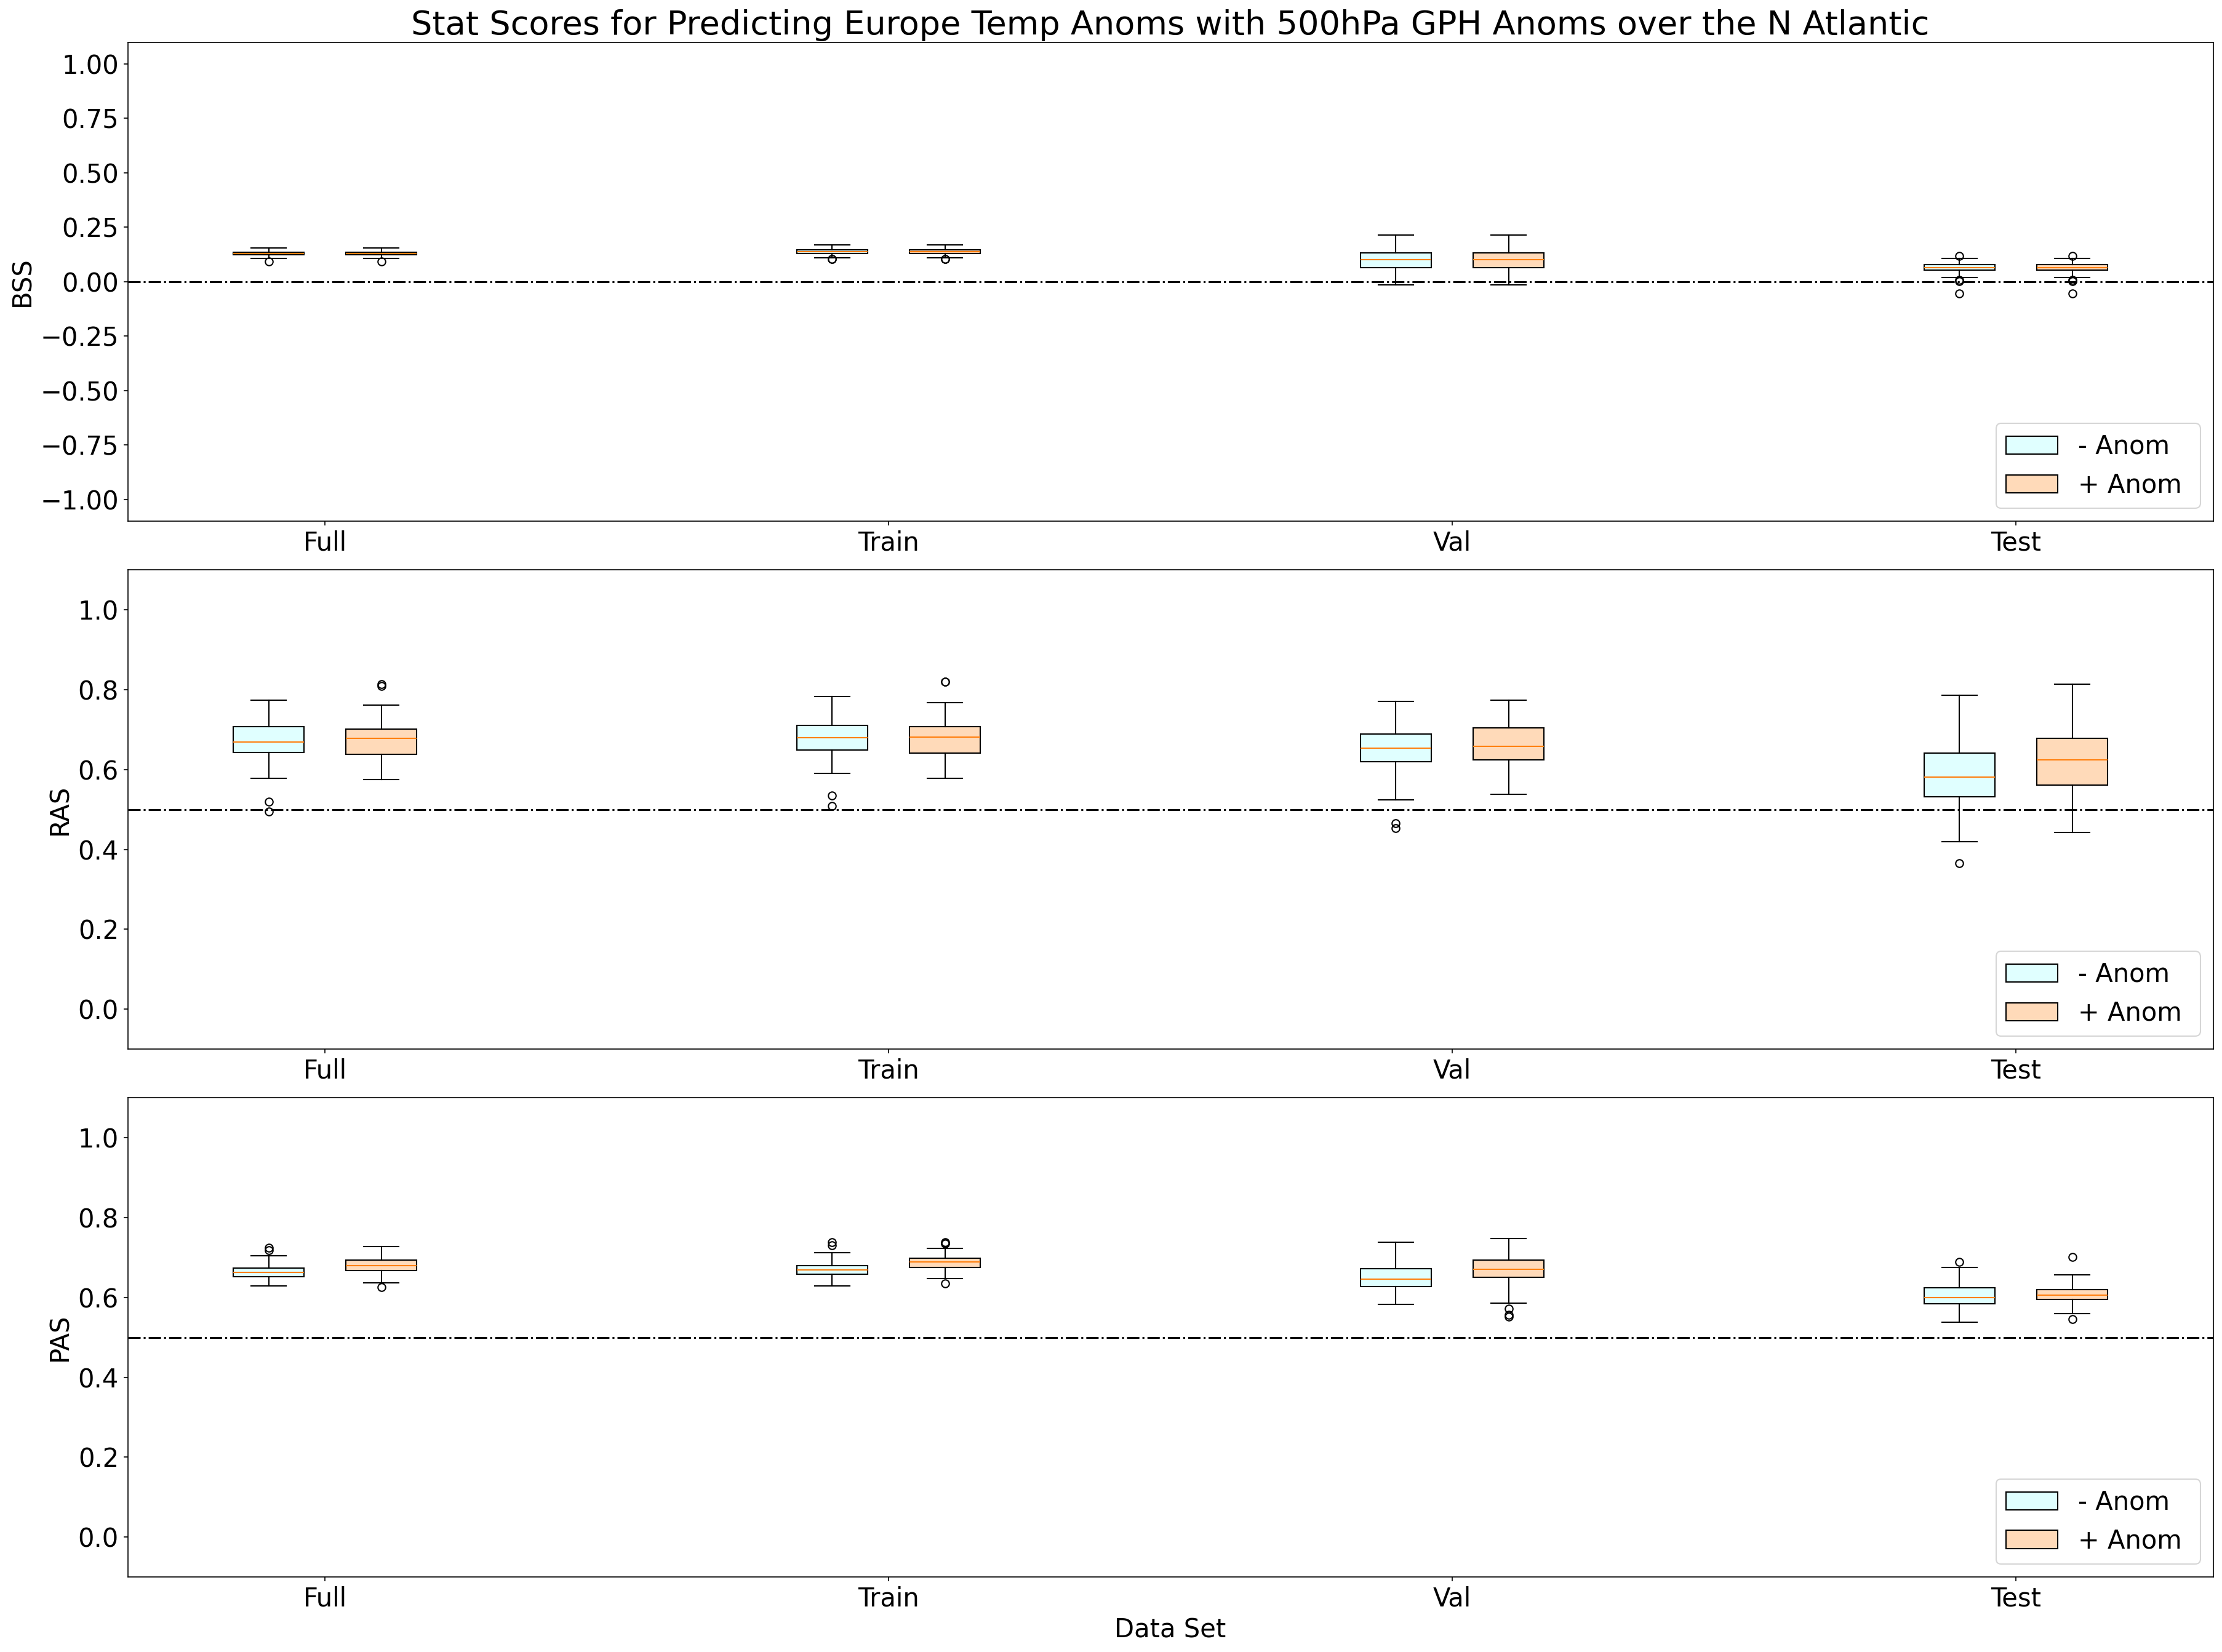

In [24]:
#plot
fig = plt.figure(figsize=(24,18),dpi=150)
font = 20
#loop through each member
ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)

ticks = ['Full', 'Train', 'Val', 'Test'] #set tick numbers for dataset
colors = ['lightcyan','peachpuff']
ind = [2, 4, 6, 8]  # the x locations for the groups
w = 0.25 #box-plot width
labels = ['- Anom', '+ Anom '] #labels of quantiles


##begin to go plot by plot ...
#each plot has a separate plot function for each lead time. In these, the plots get each quantile plotted. 
ax1.set_title("Stat Scores for Predicting Europe Temp Anoms with 500hPa GPH Anoms over the N Atlantic",fontsize = 26) 

a1_0 = ax1.boxplot([BSS_all[:,0],BSS_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a1_5 = ax1.boxplot([BSS_train[:,0],BSS_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a1_10 = ax1.boxplot([BSS_val[:,0],BSS_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a1_14 = ax1.boxplot([BSS_test[:,0],BSS_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax1.axhline(0, c='k', ls ='-.')
ax1.set_xticks(ind, ticks)
#next few lines color the box plot faces
for bplot in (a1_0, a1_5, a1_10, a1_14,):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a1_0['boxes'], labels):
    patch.set_label(label)
#ax1.set_title('BSS for Temperature Region',fontsize = 14)
ax1.set_ylim(-1.1,1.1)
#ax1.set_xlabel('Data Set',fontsize = 14)
ax1.set_ylabel('BSS',fontsize = font)
ax1.tick_params(axis='both', which='major', labelsize= font)
ax1.legend(loc = 'lower right', fontsize = font)

##repeat the process
a2_0 = ax2.boxplot([Rec_all[:,0],Rec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a2_5 = ax2.boxplot([Rec_train[:,0],Rec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a2_10 = ax2.boxplot([Rec_val[:,0],Rec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a2_14 = ax2.boxplot([Rec_test[:,0],Rec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax2.axhline(0.5, c='k', ls ='-.')
ax2.set_xticks(ind, ticks)
for bplot in (a2_0, a2_5, a2_10, a2_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a2_0['boxes'], labels):
    patch.set_label(label)
#ax2.set_title('RAS for Temperature Region',fontsize = 14)
ax2.set_ylim(-0.1,1.1)
ax2.tick_params(axis='both', which='major', labelsize= font)
ax2.set_ylabel('RAS',fontsize = font)
#ax2.set_xlabel('Data Set',fontsize = 14)
#ax2.set_ylabel('Brier Skill Score')
ax2.legend(loc = 'lower right', fontsize = font)

a3_0 = ax3.boxplot([Prec_all[:,0],Prec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a3_5 = ax3.boxplot([Prec_train[:,0],Prec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a3_10 = ax3.boxplot([Prec_val[:,0],Prec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a3_14 = ax3.boxplot([Prec_test[:,0],Prec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax3.axhline(0.5, c='k', ls ='-.')
ax3.set_xticks(ind, ticks)
for bplot in (a3_0, a3_5, a3_10, a3_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a3_0['boxes'], labels):
    patch.set_label(label)
#ax3.set_title('RAS Well')
#ax3.set_title('PAS for Temperature Region',fontsize = 14)
ax3.set_ylim(-0.1,1.1)
ax3.set_ylabel('PAS',fontsize = font)
ax3.set_xlabel('Data Set',fontsize = font)
#ax3.set_ylabel('Recall Accuracy Score',fontsize = 14)
ax3.tick_params(axis='both', which='major', labelsize= font)
ax3.legend(loc = 'lower right', fontsize = font)

plt.tight_layout()
#plt.show()
#plt.savefig("NAOTemp_StatScore_test.png")


In [25]:
#lat
lats = np.arange(80, 29.5, -2.5)
#lon
lons = np.arange(-100, -9.5, 2.5)

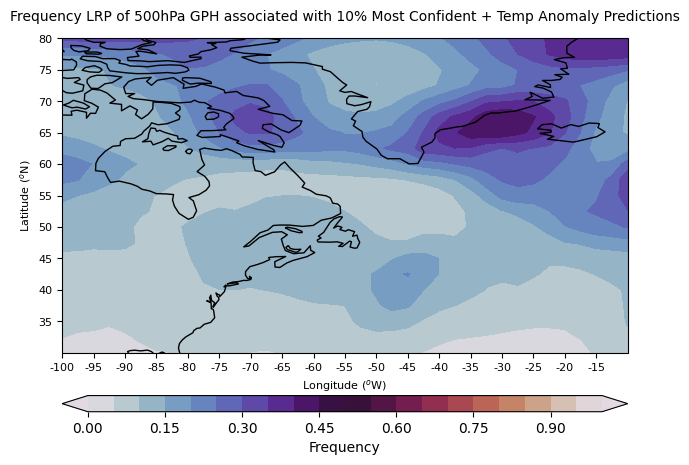

In [40]:
# plot the original data 
color = 'twilight' 
colorbarMin = 0
colorbarMax = 1
colorspace = 0.05
level = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
ax = plt.axes(projection=ccrs.cartopy.crs.PlateCarree(central_longitude=180))
h = ax.contourf(lons, lats, np.nanmean(pos90_LRP,axis=0), level, transform=ccrs.PlateCarree(), cmap=color,extend='both')
#plt.contourf(lons, lats, LRP_heatmaps_mean, level, cmap=color,extend='both')
cbar = plt.colorbar(h, orientation='horizontal', shrink=1,fraction=0.1,pad=0.1,aspect=35, label= "Frequency")
cbar.ax.tick_params(labelsize=10) 
#Add in the coordinate system:
long = np.arange(-100, -10, 5)
latg = np.arange(80, 30 ,-5)
ax.set_xticks(long, crs=ccrs.PlateCarree());
ax.set_yticks(latg, crs=ccrs.PlateCarree());
ax.set_xticklabels(long,fontsize=8)
ax.set_yticklabels(latg,fontsize=8)
ax.set_ylabel('Latitude ($^o$N)',fontsize=8);
ax.set_xlabel('Longitude ($^o$W)',fontsize=8);

#Add in the continents
#define the coastlines, the color (#000000) and the resolution (110m) 
feature1 = cf.NaturalEarthFeature(
    name='coastline', category='physical',
    scale='110m',
    edgecolor='#000000', facecolor='none')

ax.add_feature(feature1)

plt.tight_layout()
#Set a title for your map:
title = 'Frequency LRP of 500hPa GPH associated with 10% Most Confident + Temp Anomaly Predictions'
plt.title(title,fontsize=10, y=1.03)
plt.savefig("Pos_LRP.png")

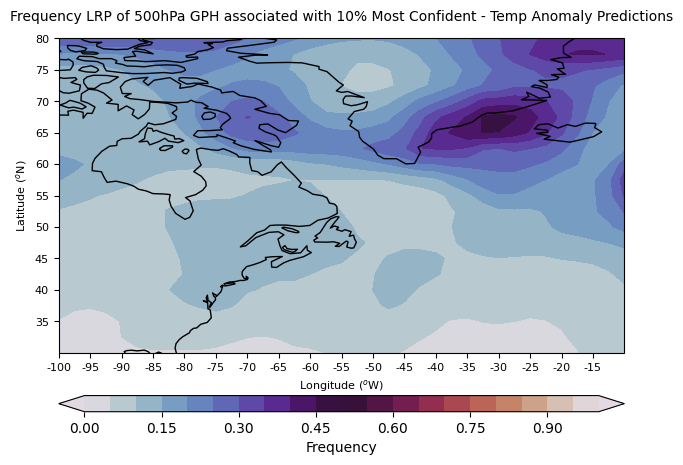

In [42]:
# plot the original data 
color = 'twilight' 
colorbarMin = 0
colorbarMax = 1
colorspace = 0.05
level = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
ax = plt.axes(projection=ccrs.cartopy.crs.PlateCarree(central_longitude=180))
h = ax.contourf(lons, lats, np.nanmean(neg90_LRP,axis=0), level, transform=ccrs.PlateCarree(), cmap=color,extend='both')
#plt.contourf(lons, lats, LRP_heatmaps_mean, level, cmap=color,extend='both')
cbar = plt.colorbar(h, orientation='horizontal', shrink=1,fraction=0.1,pad=0.1,aspect=35, label = "Frequency")
cbar.ax.tick_params(labelsize=10) 
#Add in the coordinate system:
long = np.arange(-100, -10, 5)
latg = np.arange(80, 30 ,-5)
ax.set_xticks(long, crs=ccrs.PlateCarree());
ax.set_yticks(latg, crs=ccrs.PlateCarree());
ax.set_xticklabels(long,fontsize=8)
ax.set_yticklabels(latg,fontsize=8)
ax.set_ylabel('Latitude ($^o$N)',fontsize=8);
ax.set_xlabel('Longitude ($^o$W)',fontsize=8);

#Add in the continents
#define the coastlines, the color (#000000) and the resolution (110m) 
feature1 = cf.NaturalEarthFeature(
    name='coastline', category='physical',
    scale='110m',
    edgecolor='#000000', facecolor='none')

ax.add_feature(feature1)

plt.tight_layout()
#Set a title for your map:
title = 'Frequency LRP of 500hPa GPH associated with 10% Most Confident - Temp Anomaly Predictions'
plt.title(title,fontsize=10, y=1.03)
plt.savefig("Neg_LRP.png")

## Percentile ACC Plots

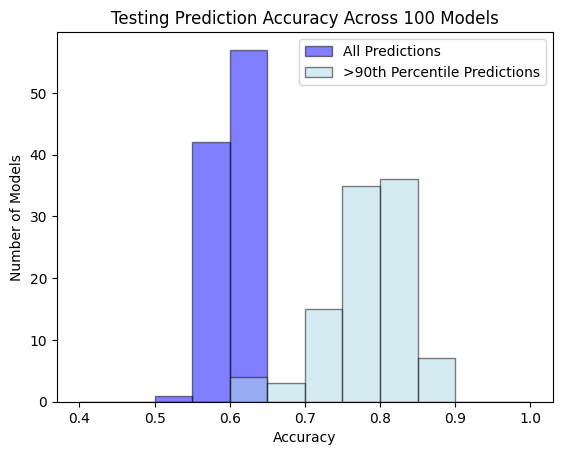

In [31]:
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(test90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fulltest_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy')
plt.ylabel('Number of Models')
plt.legend()
plt.title('Testing Prediction Accuracy Across 100 Models')
plt.show()
#plt.savefig("ACCtest.png")

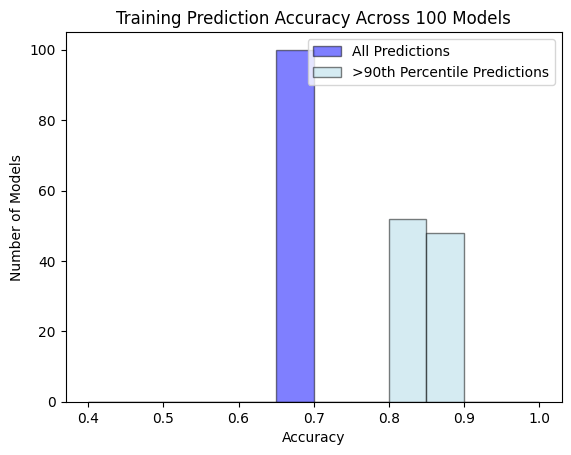

In [32]:
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(train90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fulltrain_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy')
plt.ylabel('Number of Models')
plt.legend()
plt.title('Training Prediction Accuracy Across 100 Models')
plt.show()
#plt.savefig("ACCtest.png")

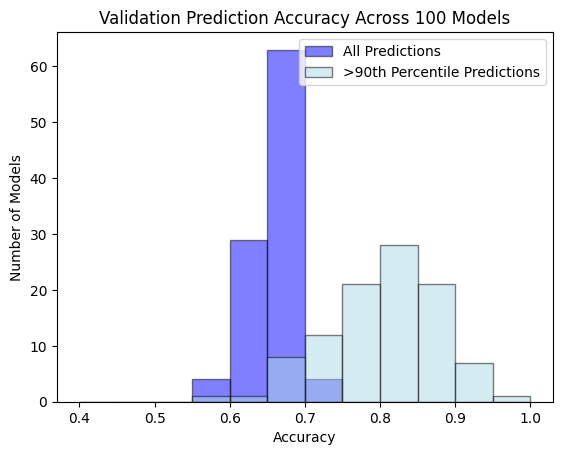

In [33]:
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(val90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fullval_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy')
plt.ylabel('Number of Models')
plt.legend()
plt.title('Validation Prediction Accuracy Across 100 Models')
plt.show()
#plt.savefig("ACCtest.png")